# Chess Game Analysis Dashboard

This notebook provides a comprehensive analysis of your Chess.com games, including:
- Opening performance analysis
- Tactical pattern recognition
- Time management insights
- Rating progression tracking
- Personalized improvement recommendations

## Setup

First, let's import the necessary libraries and set up our analysis environment.

In [1]:
# Import required libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Add src and config directories to path
sys.path.append('../src')
sys.path.append('../config')
sys.path.append('..')

# Import our custom modules
from src.data_fetcher import ChessComDataFetcher
from src.game_parser import GameParser
from src.analyzers.opening_analyzer import OpeningAnalyzer
from config.settings import Config

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")
print(f"📁 Working directory: {os.getcwd()}")

✅ Libraries imported successfully!
📁 Working directory: /Users/martinhynie/Documents/GitHub/chessAnalysit/notebooks


## Configuration

Set up your Chess.com username and analysis parameters.

In [2]:
# Configuration
USERNAME = "vds4321"  # Your Chess.com username
ANALYSIS_MONTHS = 3  # Number of months to analyze (set to None for all games)
TIME_CONTROLS = ["bullet", "blitz", "rapid"]  # Time controls to include

# Update config if username is provided
if USERNAME != "your_username_here":
    Config.CHESS_COM_USERNAME = USERNAME
    print(f"✅ Username set to: {USERNAME}")
else:
    print("⚠️  Please update the USERNAME variable with your Chess.com username")

print(f"📊 Analysis period: {ANALYSIS_MONTHS} months" if ANALYSIS_MONTHS else "📊 Analysis period: All available games")
print(f"⏱️  Time controls: {', '.join(TIME_CONTROLS)}")

✅ Username set to: vds4321
📊 Analysis period: 6 months
⏱️  Time controls: bullet, blitz, rapid


## Step 1: Download Games

Download your recent games from Chess.com. This may take a few minutes depending on how many games you have.

In [3]:
# Initialize data fetcher
fetcher = ChessComDataFetcher(USERNAME)

# Set date range if specified
end_date = datetime.now()
start_date = end_date - timedelta(days=30 * ANALYSIS_MONTHS) if ANALYSIS_MONTHS else None

print(f"🔄 Downloading games for {USERNAME}...")
if start_date:
    print(f"📅 Date range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

# Download games
try:
    games = fetcher.get_all_games(start_date=start_date, end_date=end_date)
    
    if games:
        # Filter by time control if specified
        if TIME_CONTROLS:
            filtered_games = []
            for game in games:
                time_class = game.get('time_class', '')
                if time_class in TIME_CONTROLS:
                    filtered_games.append(game)
            games = filtered_games
        
        print(f"✅ Downloaded {len(games)} games")
        
        # Save games
        games_file = fetcher.save_games_to_file(games)
        print(f"💾 Games saved to: {games_file}")
    else:
        print("❌ No games found for the specified criteria")
        
except Exception as e:
    print(f"❌ Error downloading games: {e}")
    print("Please check your username and internet connection")

INFO:data_fetcher:Fetching games for vds4321


🔄 Downloading games for vds4321...
📅 Date range: 2025-03-10 to 2025-09-06


Fetching game archives: 100%|██████████| 5/5 [00:01<00:00,  4.53it/s]
INFO:data_fetcher:Fetched 549 games
INFO:data_fetcher:Saved 548 games to data/raw/vds4321_games_20250906_193646.json


✅ Downloaded 548 games
💾 Games saved to: data/raw/vds4321_games_20250906_193646.json


## Step 2: Parse and Analyze Games

Parse the downloaded games and extract detailed analysis data. This step uses the Stockfish engine for position evaluation.

In [5]:
# Initialize game parser
parser = GameParser()

print(f"🔄 Parsing {len(games)} games...")
print("⚠️  This may take several minutes depending on the number of games and analysis depth")

try:
    # Parse games in batches
    parsed_games = parser.parse_games_batch(games)
    
    if parsed_games:
        print(f"✅ Successfully parsed {len(parsed_games)} games")
        
        # Save parsed games
        output_path = os.path.join(Config.PROCESSED_DATA_DIR, "parsed_games.json")
        os.makedirs(Config.PROCESSED_DATA_DIR, exist_ok=True)
        
        with open(output_path, 'w') as f:
            json.dump(parsed_games, f, indent=2, default=str)
        
        print(f"💾 Parsed games saved to: {output_path}")
    else:
        print("❌ No games could be parsed")
        
except Exception as e:
    print(f"❌ Error parsing games: {e}")
    print("This might be due to missing Stockfish engine or invalid PGN data")

INFO:game_parser:Stockfish engine initialized successfully
INFO:game_parser:Parsing game 1/548


🔄 Parsing 548 games...
⚠️  This may take several minutes depending on the number of games and analysis depth


INFO:game_parser:Parsing game 2/548
INFO:game_parser:Parsing game 3/548
INFO:game_parser:Parsing game 4/548
INFO:game_parser:Parsing game 5/548
INFO:game_parser:Parsing game 6/548
INFO:game_parser:Parsing game 7/548
INFO:game_parser:Parsing game 8/548
INFO:game_parser:Parsing game 9/548
INFO:game_parser:Parsing game 10/548
INFO:game_parser:Parsing game 11/548
INFO:game_parser:Parsing game 12/548
INFO:game_parser:Parsing game 13/548
INFO:game_parser:Parsing game 14/548
INFO:game_parser:Parsing game 15/548
INFO:game_parser:Parsing game 16/548
INFO:game_parser:Parsing game 17/548
INFO:game_parser:Parsing game 18/548
INFO:game_parser:Parsing game 19/548
INFO:game_parser:Parsing game 20/548
INFO:game_parser:Parsing game 21/548
INFO:game_parser:Parsing game 22/548
INFO:game_parser:Parsing game 23/548
INFO:game_parser:Parsing game 24/548
INFO:game_parser:Parsing game 25/548
INFO:game_parser:Parsing game 26/548
INFO:game_parser:Parsing game 27/548
INFO:game_parser:Parsing game 28/548
INFO:game

✅ Successfully parsed 548 games
💾 Parsed games saved to: data/processed/parsed_games.json


## Step 3: Opening Analysis

Analyze your opening performance to identify strengths and weaknesses.

In [6]:
# Initialize opening analyzer
opening_analyzer = OpeningAnalyzer()

print("🔄 Analyzing opening performance...")

# Analyze opening performance
opening_analysis = opening_analyzer.analyze_opening_performance(parsed_games)

if opening_analysis:
    print(f"✅ Analyzed {len(opening_analysis)} different openings")
    
    # Create DataFrame for easier analysis
    opening_df = pd.DataFrame.from_dict(opening_analysis, orient='index')
    opening_df = opening_df.sort_values('total_games', ascending=False)
    
    print("\n📊 Top 10 Most Played Openings:")
    print("=" * 60)
    
    for idx, (opening, row) in enumerate(opening_df.head(10).iterrows(), 1):
        print(f"{idx:2d}. {row['name'][:40]:40} | Games: {row['total_games']:3d} | Score: {row['score_percentage']:5.1f}%")
else:
    print("❌ No opening analysis data available")

🔄 Analyzing opening performance...
✅ Analyzed 64 different openings

📊 Top 10 Most Played Openings:
 1. Caro-Kann Defense                        | Games:  73 | Score:  47.3%
 2. C21                                      | Games:  43 | Score:  54.7%
 3. Queen Pawn Game                          | Games:  34 | Score:  50.0%
 4. Queen Pawn Game                          | Games:  33 | Score:  45.5%
 5. C20                                      | Games:  30 | Score:  55.0%
 6. Scandinavian Defense                     | Games:  30 | Score:  63.3%
 7. D02                                      | Games:  29 | Score:  50.0%
 8. A00                                      | Games:  27 | Score:  59.3%
 9. B00                                      | Games:  25 | Score:  58.0%
10. C23                                      | Games:  16 | Score:  68.8%


## Step 4: Opening Performance Visualization

Create interactive visualizations of your opening performance.

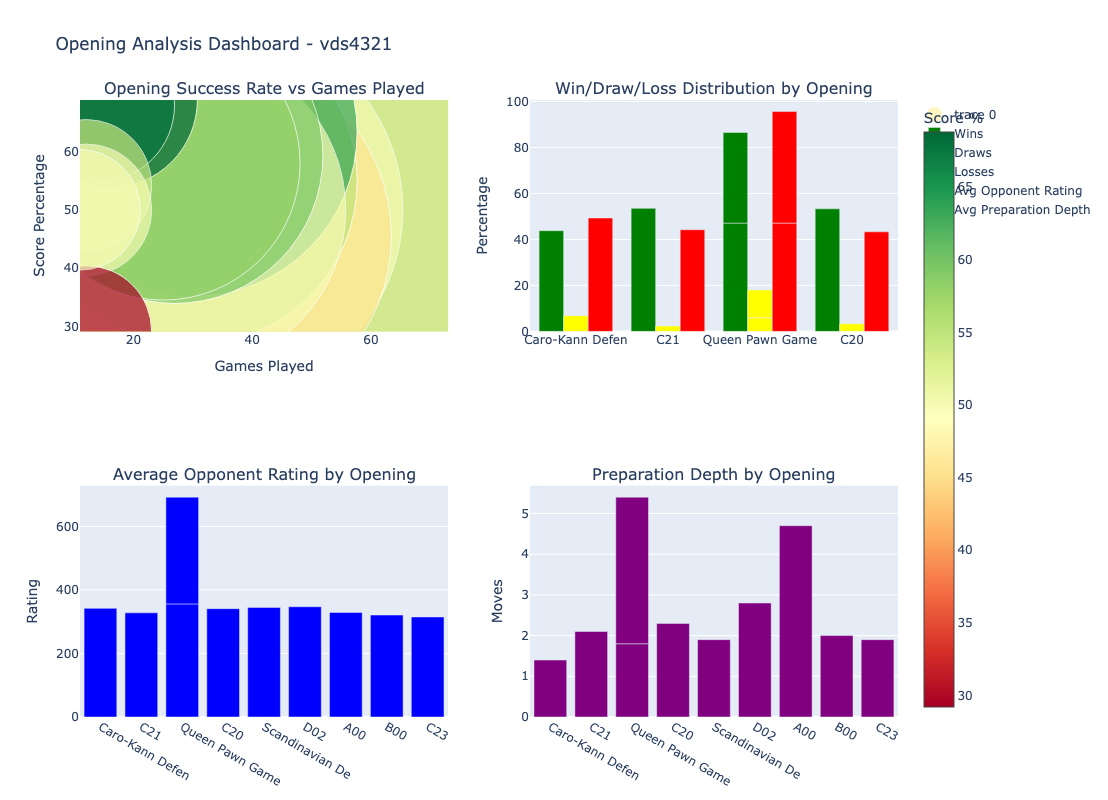

In [7]:
if opening_analysis and len(opening_df) > 0:
    # Filter openings with at least 3 games for meaningful analysis
    significant_openings = opening_df[opening_df['total_games'] >= 3].head(15)
    
    # Create opening performance chart
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Opening Success Rate vs Games Played',
            'Win/Draw/Loss Distribution by Opening',
            'Average Opponent Rating by Opening',
            'Preparation Depth by Opening'
        ),
        specs=[[{"secondary_y": False}, {"type": "bar"}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    # Chart 1: Success rate vs games played (bubble chart)
    fig.add_trace(
        go.Scatter(
            x=significant_openings['total_games'],
            y=significant_openings['score_percentage'],
            mode='markers',
            marker=dict(
                size=significant_openings['total_games'],
                sizemode='diameter',
                sizeref=2.*max(significant_openings['total_games'])/(40.**2),
                sizemin=4,
                color=significant_openings['score_percentage'],
                colorscale='RdYlGn',
                showscale=True,
                colorbar=dict(title="Score %")
            ),
            text=[name[:20] for name in significant_openings['name']],
            textposition="middle center",
            hovertemplate='<b>%{text}</b><br>Games: %{x}<br>Score: %{y:.1f}%<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Chart 2: Win/Draw/Loss distribution (stacked bar)
    top_5_openings = significant_openings.head(5)
    
    fig.add_trace(
        go.Bar(
            name='Wins',
            x=[name[:15] for name in top_5_openings['name']],
            y=top_5_openings['win_rate'],
            marker_color='green'
        ),
        row=1, col=2
    )
    
    fig.add_trace(
        go.Bar(
            name='Draws',
            x=[name[:15] for name in top_5_openings['name']],
            y=top_5_openings['draw_rate'],
            marker_color='yellow'
        ),
        row=1, col=2
    )
    
    fig.add_trace(
        go.Bar(
            name='Losses',
            x=[name[:15] for name in top_5_openings['name']],
            y=top_5_openings['loss_rate'],
            marker_color='red'
        ),
        row=1, col=2
    )
    
    # Chart 3: Average opponent rating
    fig.add_trace(
        go.Bar(
            x=[name[:15] for name in significant_openings.head(10)['name']],
            y=significant_openings.head(10)['avg_opponent_rating'],
            marker_color='blue',
            name='Avg Opponent Rating'
        ),
        row=2, col=1
    )
    
    # Chart 4: Preparation depth
    prep_data = significant_openings[significant_openings['avg_preparation_depth'] > 0].head(10)
    if len(prep_data) > 0:
        fig.add_trace(
            go.Bar(
                x=[name[:15] for name in prep_data['name']],
                y=prep_data['avg_preparation_depth'],
                marker_color='purple',
                name='Avg Preparation Depth'
            ),
            row=2, col=2
        )
    
    # Update layout
    fig.update_layout(
        height=800,
        title_text=f"Opening Analysis Dashboard - {USERNAME}",
        showlegend=True
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Games Played", row=1, col=1)
    fig.update_yaxes(title_text="Score Percentage", row=1, col=1)
    fig.update_yaxes(title_text="Percentage", row=1, col=2)
    fig.update_yaxes(title_text="Rating", row=2, col=1)
    fig.update_yaxes(title_text="Moves", row=2, col=2)
    
    fig.show()
    
else:
    print("❌ Insufficient data for opening visualization")

## Step 5: Opening Recommendations

Get personalized recommendations based on your opening performance.

In [8]:
if opening_analysis:
    # Get recommendations
    recommendations = opening_analyzer.get_opening_recommendations(opening_analysis)
    
    print("🎯 Personalized Opening Recommendations:")
    print("=" * 60)
    
    if recommendations:
        for i, rec in enumerate(recommendations, 1):
            priority_emoji = {"high": "🔴", "medium": "🟡", "low": "🟢"}
            type_emoji = {
                "strength": "💪",
                "weakness": "⚠️",
                "preparation": "📚",
                "diversity": "🎨"
            }
            
            print(f"\n{i}. {priority_emoji.get(rec['priority'], '⚪')} {type_emoji.get(rec['type'], '📊')} {rec['title']}")
            print(f"   {rec['description']}")
            
            if rec.get('stats'):
                stats = rec['stats']
                print(f"   📈 Games: {stats['total_games']}, Score: {stats['score_percentage']}%, "
                      f"Avg Opponent: {stats['avg_opponent_rating']}")
    else:
        print("No specific recommendations available. Play more games for better analysis!")
        
else:
    print("❌ No opening data available for recommendations")

🎯 Personalized Opening Recommendations:

1. 🔴 💪 Your strongest opening: Scandinavian Defense
   You score 63.3% with this opening (30 games). Consider playing it more often.
   📈 Games: 30, Score: 63.3%, Avg Opponent: 345

2. 🔴 ⚠️ Opening to improve: Scotch Game
   You score only 29.2% with this opening (12 games). Consider studying this opening more.
   📈 Games: 12, Score: 29.2%, Avg Opponent: 364

3. 🟡 📚 Improve preparation in Caro-Kann Defense
   Your average preparation depth is only 1.4 moves. Study more theory to improve your opening play.
   📈 Games: 73, Score: 47.3%, Avg Opponent: 342


## Step 6: Color-Specific Analysis

Analyze your performance with White and Black pieces separately.

In [9]:
if opening_analysis:
    # Analyze by color
    color_analysis = opening_analyzer.analyze_color_preferences(parsed_games)
    
    print("♔♛ Color-Specific Opening Analysis:")
    print("=" * 50)
    
    white_games = color_analysis['white_games']
    black_games = color_analysis['black_games']
    total_games = white_games + black_games
    
    print(f"\n📊 Game Distribution:")
    print(f"   ♔ White: {white_games} games ({white_games/total_games*100:.1f}%)")
    print(f"   ♛ Black: {black_games} games ({black_games/total_games*100:.1f}%)")
    
    # Top openings by color
    if color_analysis['white']:
        white_df = pd.DataFrame.from_dict(color_analysis['white'], orient='index')
        white_df = white_df.sort_values('total_games', ascending=False)
        
        print(f"\n♔ Top 5 White Openings:")
        for idx, (opening, row) in enumerate(white_df.head(5).iterrows(), 1):
            print(f"   {idx}. {row['name'][:35]:35} | {row['total_games']:2d} games | {row['score_percentage']:5.1f}%")
    
    if color_analysis['black']:
        black_df = pd.DataFrame.from_dict(color_analysis['black'], orient='index')
        black_df = black_df.sort_values('total_games', ascending=False)
        
        print(f"\n♛ Top 5 Black Openings:")
        for idx, (opening, row) in enumerate(black_df.head(5).iterrows(), 1):
            print(f"   {idx}. {row['name'][:35]:35} | {row['total_games']:2d} games | {row['score_percentage']:5.1f}%")
    
    # Color performance comparison
    if white_games > 0 and black_games > 0:
        white_avg_score = sum(stats['score_percentage'] * stats['total_games'] 
                             for stats in color_analysis['white'].values()) / white_games
        black_avg_score = sum(stats['score_percentage'] * stats['total_games'] 
                             for stats in color_analysis['black'].values()) / black_games
        
        print(f"\n🎯 Overall Performance:")
        print(f"   ♔ White average score: {white_avg_score:.1f}%")
        print(f"   ♛ Black average score: {black_avg_score:.1f}%")
        
        if white_avg_score > black_avg_score + 5:
            print(f"   💡 You perform significantly better with White pieces")
        elif black_avg_score > white_avg_score + 5:
            print(f"   💡 You perform significantly better with Black pieces")
        else:
            print(f"   💡 Your performance is balanced between colors")
            
else:
    print("❌ No data available for color analysis")

♔♛ Color-Specific Opening Analysis:

📊 Game Distribution:
   ♔ White: 275 games (50.2%)
   ♛ Black: 273 games (49.8%)

♔ Top 5 White Openings:
   1. C21                                 | 42 games |  56.0%
   2. Queen Pawn Game                     | 26 games |  50.0%
   3. B00                                 | 25 games |  58.0%
   4. D02                                 | 19 games |  39.5%
   5. C23                                 | 15 games |  73.3%

♛ Top 5 Black Openings:
   1. Caro-Kann Defense                   | 71 games |  48.6%
   2. A00                                 | 27 games |  59.3%
   3. C20                                 | 26 games |  48.1%
   4. Queen Pawn Game                     | 20 games |  45.0%
   5. Scandinavian Defense                | 17 games |  58.8%

🎯 Overall Performance:
   ♔ White average score: 52.6%
   ♛ Black average score: 50.7%
   💡 Your performance is balanced between colors


## Step 7: Game Statistics Summary

Overall statistics and insights from your games.

In [10]:
if parsed_games:
    print("📈 Game Statistics Summary:")
    print("=" * 40)
    
    # Basic statistics
    total_games = len(parsed_games)
    
    # Results distribution
    wins = sum(1 for game in parsed_games 
              if game.get('game_metadata', {}).get('result') == '1')
    draws = sum(1 for game in parsed_games 
               if game.get('game_metadata', {}).get('result') == '1/2')
    losses = total_games - wins - draws
    
    print(f"\n🎮 Total Games: {total_games}")
    print(f"✅ Wins: {wins} ({wins/total_games*100:.1f}%)")
    print(f"🤝 Draws: {draws} ({draws/total_games*100:.1f}%)")
    print(f"❌ Losses: {losses} ({losses/total_games*100:.1f}%)")
    print(f"📊 Overall Score: {(wins + draws*0.5)/total_games*100:.1f}%")
    
    # Time control distribution
    time_controls = {}
    for game in parsed_games:
        tc = game.get('game_metadata', {}).get('time_class', 'unknown')
        time_controls[tc] = time_controls.get(tc, 0) + 1
    
    print(f"\n⏱️  Time Control Distribution:")
    for tc, count in sorted(time_controls.items(), key=lambda x: x[1], reverse=True):
        print(f"   {tc.capitalize()}: {count} games ({count/total_games*100:.1f}%)")
    
    # Average statistics
    game_stats = [game.get('statistics', {}) for game in parsed_games if game.get('statistics')]
    
    if game_stats:
        avg_accuracy = sum(stats.get('accuracy', 0) for stats in game_stats) / len(game_stats)
        avg_blunders = sum(stats.get('blunders', 0) for stats in game_stats) / len(game_stats)
        avg_mistakes = sum(stats.get('mistakes', 0) for stats in game_stats) / len(game_stats)
        avg_inaccuracies = sum(stats.get('inaccuracies', 0) for stats in game_stats) / len(game_stats)
        
        print(f"\n🎯 Average Performance:")
        print(f"   Accuracy: {avg_accuracy:.1f}%")
        print(f"   Blunders per game: {avg_blunders:.1f}")
        print(f"   Mistakes per game: {avg_mistakes:.1f}")
        print(f"   Inaccuracies per game: {avg_inaccuracies:.1f}")
    
    # Opponent rating analysis
    opponent_ratings = [game.get('game_metadata', {}).get('opponent_rating', 0) 
                       for game in parsed_games 
                       if game.get('game_metadata', {}).get('opponent_rating', 0) > 0]
    
    if opponent_ratings:
        avg_opponent_rating = sum(opponent_ratings) / len(opponent_ratings)
        min_rating = min(opponent_ratings)
        max_rating = max(opponent_ratings)
        
        print(f"\n🏆 Opponent Ratings:")
        print(f"   Average: {avg_opponent_rating:.0f}")
        print(f"   Range: {min_rating} - {max_rating}")
        
        # Performance vs rating ranges
        rating_ranges = {
            "<1200": [0, 1200],
            "1200-1400": [1200, 1400],
            "1400-1600": [1400, 1600],
            "1600-1800": [1600, 1800],
            "1800+": [1800, 3000]
        }
        
        print(f"\n📊 Performance by Opponent Rating:")
        for range_name, (min_r, max_r) in rating_ranges.items():
            range_games = [game for game in parsed_games 
                          if min_r <= game.get('game_metadata', {}).get('opponent_rating', 0) < max_r]
            
            if range_games:
                range_wins = sum(1 for game in range_games 
                               if game.get('game_metadata', {}).get('result') == '1')
                range_draws = sum(1 for game in range_games 
                                if game.get('game_metadata', {}).get('result') == '1/2')
                range_score = (range_wins + range_draws * 0.5) / len(range_games) * 100
                
                print(f"   {range_name:10}: {len(range_games):3d} games, {range_score:5.1f}% score")
    
else:
    print("❌ No game data available for statistics")

📈 Game Statistics Summary:

🎮 Total Games: 548
✅ Wins: 264 (48.2%)
🤝 Draws: 38 (6.9%)
❌ Losses: 246 (44.9%)
📊 Overall Score: 51.6%

⏱️  Time Control Distribution:
   Rapid: 526 games (96.0%)
   Blitz: 22 games (4.0%)

🎯 Average Performance:
   Accuracy: 12.2%
   Blunders per game: 15.7
   Mistakes per game: 2.2
   Inaccuracies per game: 2.7

🏆 Opponent Ratings:
   Average: 337
   Range: 101 - 580

📊 Performance by Opponent Rating:
   <1200     : 548 games,  51.6% score


## Next Steps

This analysis provides a comprehensive overview of your chess performance. Here are some suggestions for further analysis:

1. **Tactical Analysis**: Run the tactical analyzer to identify missed opportunities and blunder patterns
2. **Time Management**: Analyze how you use your time during games\n3. **Endgame Analysis**: Study your endgame conversion rates and defensive skills\n4. **Rating Progression**: Track your rating changes over time\n5. **Detailed Game Review**: Examine specific games for learning opportunities\n\nUse the other notebooks in this directory for specialized analysis:\n- `opening_deep_dive.ipynb` - Detailed opening analysis\n- `tactical_review.ipynb` - Tactical pattern analysis\n- `performance_trends.ipynb` - Long-term performance tracking\n\nHappy analyzing! 🚀